In [1]:
import time
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [6]:
data = pd.read_csv('C:/Users/Alex/Desktop/기계학습/combined.csv')
data = data.drop('Unnamed: 0',axis=1)
data

,lrate,llevel,leaktype,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
0,90,256,out,0,18,19,16,20,19,17,...,4690,243,4710,284,4700,324,4670,230,4710,260
1,90,542,out,0,4,2,4,6,4,6,...,310,423,300,711,270,412,270,531,290,538
2,90,705,out,0,0,0,3,3,3,3,...,240,751,240,897,240,741,240,741,240,562
3,90,499,out,0,2,2,2,2,2,2,...,370,549,360,427,370,800,370,552,370,458
4,90,423,out,0,3,3,3,3,3,3,...,400,521,400,395,400,461,400,470,400,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62559,30,283,normal,0,4,3,3,4,4,4,...,190,44,260,60,190,32,260,439,260,77
62560,40,164,normal,0,4,4,5,4,4,4,...,260,196,260,65,260,52,260,38,260,58
62561,70,162,normal,0,4,4,4,5,5,4,...,310,147,290,162,290,226,290,171,310,98
62562,30,159,normal,0,4,5,5,5,5,5,...,390,58,380,94,380,61,380,133,380,67


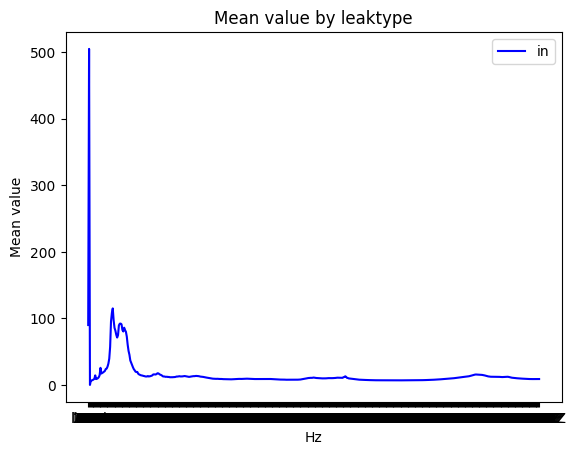

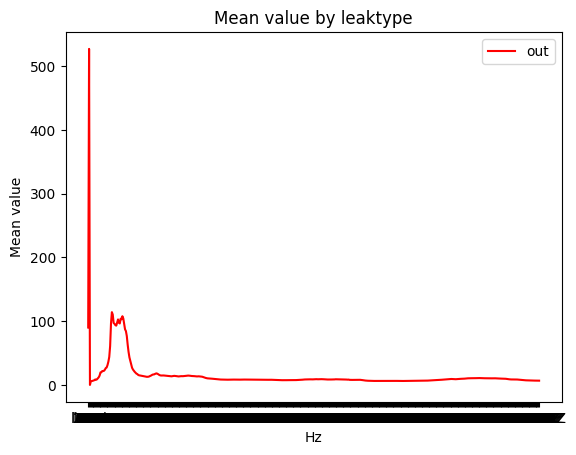

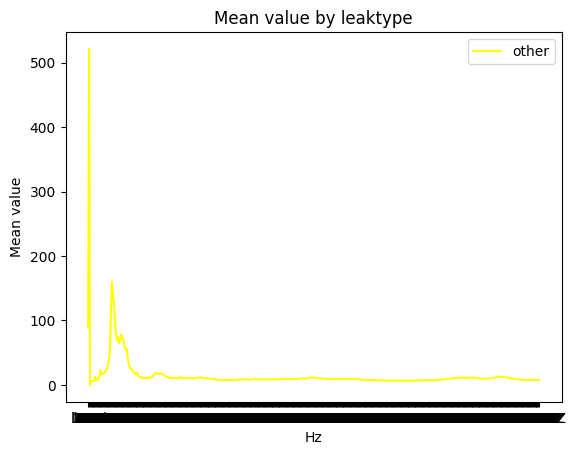

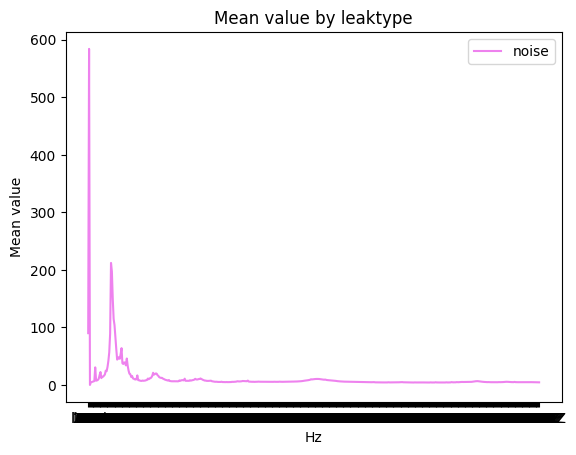

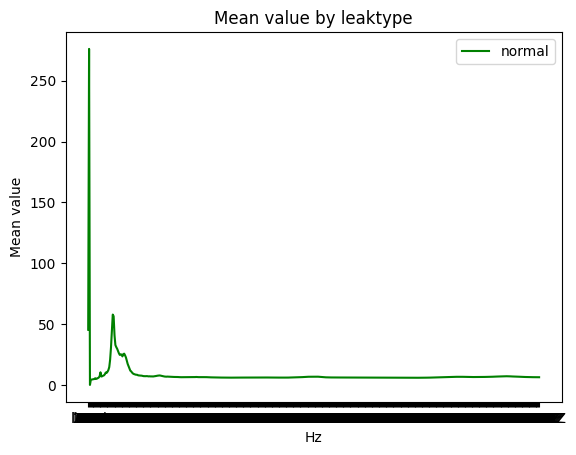

In [7]:
in_data = data[data['leaktype'] == 'in'].select_dtypes(include=[np.number]).drop(columns=['MAX0', 'MAX1', 'MAX2', 'MAX3', 'MAX4', 'MAX5', 'MAX6', 'MAX7', 'MAX8', 'MAX9', 'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17', 'MAX18', 'MAX19'])
out_data = data[data['leaktype'] == 'out'].select_dtypes(include=[np.number]).drop(columns=['MAX0', 'MAX1', 'MAX2', 'MAX3', 'MAX4', 'MAX5', 'MAX6', 'MAX7', 'MAX8', 'MAX9', 'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17', 'MAX18', 'MAX19'])
other_data = data[data['leaktype'] == 'other'].select_dtypes(include=[np.number]).drop(columns=['MAX0', 'MAX1', 'MAX2', 'MAX3', 'MAX4', 'MAX5', 'MAX6', 'MAX7', 'MAX8', 'MAX9', 'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17', 'MAX18', 'MAX19'])
normal_data = data[data['leaktype'] == 'normal'].select_dtypes(include=[np.number]).drop(columns=['MAX0', 'MAX1', 'MAX2', 'MAX3', 'MAX4', 'MAX5', 'MAX6', 'MAX7', 'MAX8', 'MAX9', 'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17', 'MAX18', 'MAX19'])
noise_data = data[data['leaktype'] == 'noise'].select_dtypes(include=[np.number]).drop(columns=['MAX0', 'MAX1', 'MAX2', 'MAX3', 'MAX4', 'MAX5', 'MAX6', 'MAX7', 'MAX8', 'MAX9', 'MAX10', 'MAX11', 'MAX12', 'MAX13', 'MAX14', 'MAX15', 'MAX16', 'MAX17', 'MAX18', 'MAX19'])

in_mean = in_data.mean()
out_mean = out_data.mean()
other_mean = other_data.mean()
normal_mean = normal_data.mean()
noise_mean = noise_data.mean()

# 선 그래프 그리기
plt.plot(in_mean, label='in', color='blue')
plt.xlabel('Hz')
plt.ylabel('Mean value')
plt.title('Mean value by leaktype')
plt.legend(loc='best')
plt.show()

plt.plot(out_mean, label='out', color='red')
plt.xlabel('Hz')
plt.ylabel('Mean value')
plt.title('Mean value by leaktype')
plt.legend(loc='best')
plt.show()

plt.plot(other_mean, label='other', color='yellow')
plt.xlabel('Hz')
plt.ylabel('Mean value')
plt.title('Mean value by leaktype')
plt.legend(loc='best')
plt.show()

plt.plot(noise_mean, label='noise', color='violet')
plt.xlabel('Hz')
plt.ylabel('Mean value')
plt.title('Mean value by leaktype')
plt.legend(loc='best')
plt.show()

plt.plot(normal_mean, label='normal', color='green')
plt.xlabel('Hz')
plt.ylabel('Mean value')
plt.title('Mean value by leaktype')
plt.legend(loc='best')
plt.show()

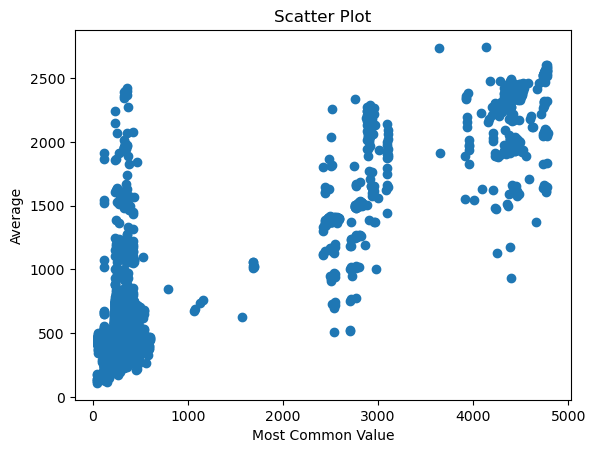

In [4]:
in_max = data[data['leaktype'] == 'in']
in_max = in_max.loc[:, 'MAX0':'MAX19']

selected_in_cols = in_max.iloc[:, [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]]

most_common_in_values = selected_in_cols.apply(lambda row: row.value_counts().idxmax(), axis=1)

averages_in = []

for row in range(in_max.shape[0]):
    selected_in_cols_indices = [i+1 for i, col in enumerate(selected_in_cols.columns) if col in selected_in_cols.columns[(selected_in_cols == most_common_in_values[row]).any()].tolist()]
    average_in_cols = [int(col[3:]) for col in in_max.columns[selected_in_cols_indices]]
    average_in_values = in_max.iloc[row, average_in_cols].mean()
    averages_in.append(average_in_values)

Most_Frequent_in = pd.DataFrame({'Most Common Value': most_common_in_values, 'Average': averages_in})

plt.scatter(Most_Frequent_in['Most Common Value'], Most_Frequent_in['Average'])
plt.xlabel('Most Common Value')
plt.ylabel('Average')
plt.title('Scatter Plot')
plt.show()

In [5]:
max_all = data.loc[:, 'MAX0':'MAX19']

selected_cols = max_all.iloc[:, [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]]

most_common_values = selected_cols.apply(lambda row: row.value_counts().idxmax(), axis=1)

averages = []

for row in range(max_all.shape[0]):
    selected_cols_indices = [i+1 for i, col in enumerate(selected_cols.columns) if col in selected_cols.columns[(selected_cols == most_common_values[row]).any()].tolist()]
    average_cols = [int(col[3:]) for col in max_all.columns[selected_cols_indices]]
    average_values = max_all.iloc[row, average_cols].mean()
    averages.append(average_values)

Most_Frequent = pd.DataFrame({'Most Common Value': most_common_values, 'Average': averages})

Most_Frequent

,Most Common Value,Average
0,430,336.5
1,240,298.0
2,260,345.1
3,430,314.7
4,400,448.0
...,...,...
62559,260,518.5
62560,230,420.9
62561,240,253.1
62562,240,425.4


In [6]:
X = data.drop(["lrate", "llevel", "leaktype"], axis=1)
X = pd.concat([X, Most_Frequent], axis=1)
X = X.drop(["MAX0", "MAX1", "MAX2","MAX3", "MAX4", "MAX5","MAX6", "MAX7", "MAX8","MAX9", "MAX10", "MAX11","MAX12", "MAX13", "MAX14", "MAX15", "MAX16", "MAX17", "MAX18", "MAX19",], axis=1)
Y1 = data["lrate"]
Y2 = data["llevel"]
Y3 = data["leaktype"]

X

,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,100HZ,...,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ,Most Common Value,Average
0,5,5,5,5,6,5,5,6,5,6,...,21,17,23,25,21,23,17,22,430,336.5
1,3,3,4,4,4,4,4,4,4,6,...,6,9,7,7,6,6,7,6,240,298.0
2,11,15,16,18,18,18,19,27,24,27,...,23,24,29,26,27,29,27,27,260,345.1
3,11,11,11,11,10,11,12,13,12,12,...,32,31,32,38,30,35,34,40,430,314.7
4,4,4,4,4,4,4,6,6,6,9,...,2,4,2,4,2,2,4,4,400,448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62559,0,0,0,0,0,3,0,0,0,3,...,0,3,3,3,3,0,3,0,260,518.5
62560,2,0,0,0,0,2,2,5,5,7,...,0,2,2,2,2,2,2,0,230,420.9
62561,4,4,4,4,3,6,4,4,4,6,...,6,6,6,6,7,6,4,6,240,253.1
62562,2,2,0,2,2,2,5,5,7,7,...,2,2,2,2,2,2,2,2,240,425.4


[누수 타입 예측]

In [61]:
# 학습 데이터와 테스트 데이터 분리
X_type_train, X_type_test, y_type_train, y_type_test = train_test_split(X, Y3, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model_type = RandomForestClassifier()

# 모델 학습
rf_model_type.fit(X_type_train, y_type_train)

# 테스트 데이터 예측
y_type_pred = rf_model_type.predict(X_type_test)

# 성능 지표 출력
type_accuracy = accuracy_score(y_type_test, y_type_pred)
type_precision = precision_score(y_type_test, y_type_pred, average='macro')
type_recall = recall_score(y_type_test, y_type_pred, average='macro')
type_f1 = f1_score(y_type_test, y_type_pred, average='macro')

print("정확도:", type_accuracy)
print("정밀도:", type_precision)
print("재현율:", type_recall)
print("F1-점수:", type_f1)

정확도: 0.8827619275953009
정밀도: 0.8815316762524888
재현율: 0.8325905557989067
F1-점수: 0.8527913240950072


In [8]:
# 학습 데이터와 테스트 데이터 분리
X_type_train, X_type_test, y_type_train, y_type_test = train_test_split(X, Y3, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model_type = RandomForestClassifier(n_estimators=2000, max_depth=15)

# 모델 학습
rf_model_type.fit(X_type_train, y_type_train)

# 테스트 데이터 예측
y_type_pred = rf_model_type.predict(X_type_test)

# 성능 지표 출력
type_accuracy = accuracy_score(y_type_test, y_type_pred)
type_precision = precision_score(y_type_test, y_type_pred, average='macro')
type_recall = recall_score(y_type_test, y_type_pred, average='macro')
type_f1 = f1_score(y_type_test, y_type_pred, average='macro')

print("정확도:", type_accuracy)
print("정밀도:", type_precision)
print("재현율:", type_recall)
print("F1-점수:", type_f1)

정확도: 0.8187485015583793
정밀도: 0.8334008683588818
재현율: 0.7361370130284852
F1-점수: 0.7662867930823178


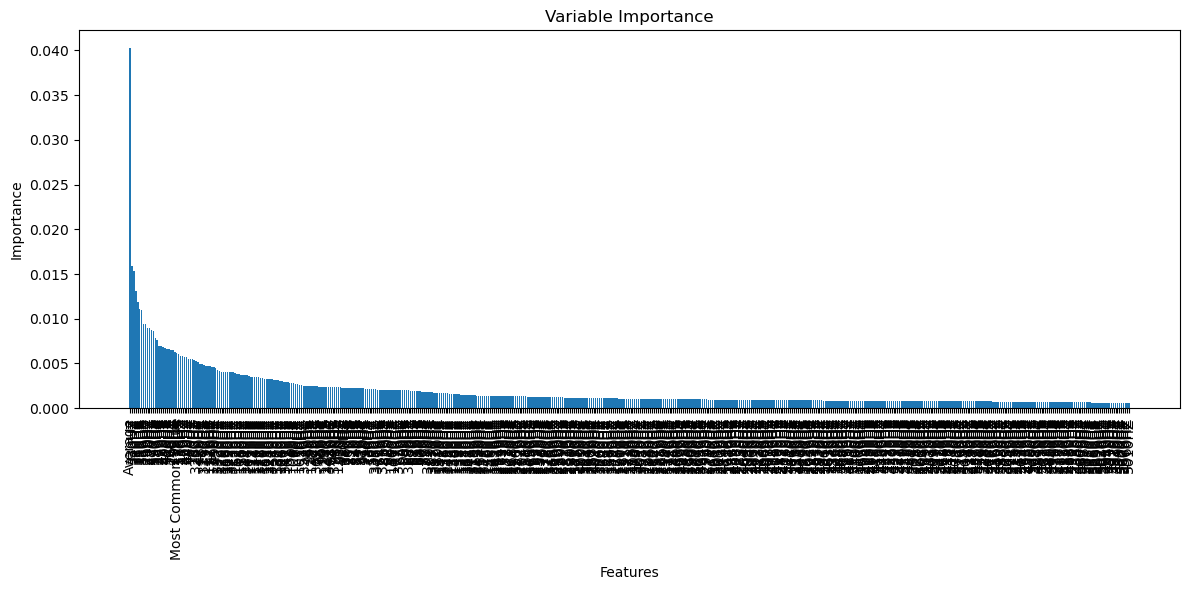

In [9]:
# 변수 중요도 추출
importances = rf_model_type.feature_importances_

# 변수 중요도를 내림차순으로 정렬
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = X_type_train.columns[sorted_indices]  # 변수(특성)의 이름

# 중요도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.show()

In [16]:
threshold = 0.003  # 일정 중요도 임계값 설정
selected_features = sorted_features[sorted_importances >= threshold]

selected_features

Index(['Average', '330HZ', '340HZ', '320HZ', '310HZ', '190HZ', '350HZ',
       '360HZ', '210HZ', '200HZ', '240HZ', '220HZ', '370HZ', '390HZ', '380HZ',
       '230HZ', '420HZ', '250HZ', '400HZ', '410HZ', '300HZ', '260HZ', '140HZ',
       '290HZ', 'Most Common Value', '280HZ', '130HZ', '270HZ', '460HZ',
       '430HZ', '440HZ', '450HZ', '180HZ', '150HZ', '3260HZ', '170HZ', '480HZ',
       '160HZ', '3270HZ', '1130HZ', '120HZ', '1170HZ', '470HZ', '1140HZ',
       '490HZ', '3320HZ', '1230HZ', '3290HZ', '1260HZ', '1180HZ', '1090HZ',
       '3220HZ', '3250HZ', '3230HZ', '1120HZ', '510HZ', '1080HZ', '1160HZ',
       '500HZ', '1110HZ', '3440HZ', '1070HZ', '1190HZ', '110HZ', '1240HZ',
       '1100HZ', '1210HZ', '3280HZ', '1200HZ', '1150HZ', '1030HZ', '1250HZ',
       '3240HZ', '3310HZ', '540HZ', '1220HZ', '3300HZ', '1040HZ', '1060HZ'],
      dtype='object')

In [17]:
th_X = X[['Average', '330HZ', '340HZ', '320HZ', '310HZ', '190HZ', '350HZ',
       '360HZ', '210HZ', '200HZ', '240HZ', '220HZ', '370HZ', '390HZ', '380HZ',
       '230HZ', '420HZ', '250HZ', '400HZ', '410HZ', '300HZ', '260HZ', '140HZ',
       '290HZ', 'Most Common Value', '280HZ', '130HZ', '270HZ', '460HZ',
       '430HZ', '440HZ', '450HZ', '180HZ', '150HZ', '3260HZ', '170HZ', '480HZ',
       '160HZ', '3270HZ', '1130HZ', '120HZ', '1170HZ', '470HZ', '1140HZ',
       '490HZ', '3320HZ', '1230HZ', '3290HZ', '1260HZ', '1180HZ', '1090HZ',
       '3220HZ', '3250HZ', '3230HZ', '1120HZ', '510HZ', '1080HZ', '1160HZ',
       '500HZ', '1110HZ', '3440HZ', '1070HZ', '1190HZ', '110HZ', '1240HZ',
       '1100HZ', '1210HZ', '3280HZ', '1200HZ', '1150HZ', '1030HZ', '1250HZ',
       '3240HZ', '3310HZ', '540HZ', '1220HZ', '3300HZ', '1040HZ', '1060HZ']]

th_X

,Average,330HZ,340HZ,320HZ,310HZ,190HZ,350HZ,360HZ,210HZ,200HZ,...,1150HZ,1030HZ,1250HZ,3240HZ,3310HZ,540HZ,1220HZ,3300HZ,1040HZ,1060HZ
0,336.5,46,35,37,36,8,47,37,7,8,...,7,8,12,9,7,14,10,9,8,9
1,298.0,25,19,28,37,22,13,13,33,27,...,6,6,6,6,4,4,4,4,4,7
2,345.1,77,55,61,66,34,45,31,37,34,...,18,21,18,16,19,26,18,16,21,19
3,314.7,23,22,20,19,14,25,25,15,13,...,15,14,20,16,15,34,16,15,13,17
4,448.0,88,78,73,121,67,80,93,45,37,...,15,9,7,4,4,17,13,4,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62559,518.5,54,70,48,45,18,48,27,39,27,...,3,3,3,3,3,3,3,0,3,3
62560,420.9,20,14,23,23,91,14,11,125,184,...,16,2,5,2,2,2,9,2,2,5
62561,253.1,9,7,8,10,14,6,6,38,21,...,7,4,7,7,4,7,7,6,4,4
62562,425.4,20,23,29,32,104,20,16,143,190,...,18,5,7,2,2,5,9,2,5,5


In [26]:
# 학습 데이터와 테스트 데이터 분리
X_type_train, X_type_test, y_type_train, y_type_test = train_test_split(th_X, Y3, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model_type = RandomForestClassifier(n_estimators=2000, max_depth=10)

# 모델 학습
rf_model_type.fit(X_type_train, y_type_train)

# 테스트 데이터 예측
y_type_pred = rf_model_type.predict(X_type_test)

# 성능 지표 출력
type_accuracy = accuracy_score(y_type_test, y_type_pred)
type_precision = precision_score(y_type_test, y_type_pred, average='macro')
type_recall = recall_score(y_type_test, y_type_pred, average='macro')
type_f1 = f1_score(y_type_test, y_type_pred, average='macro')

print("정확도:", type_accuracy)
print("정밀도:", type_precision)
print("재현율:", type_recall)
print("F1-점수:", type_f1)

정확도: 0.7310796771357788
정밀도: 0.7655675151625904
재현율: 0.6140175565282954
F1-점수: 0.6402666194066612


XGBoost(하이퍼파라미터 설정X)

In [25]:
# 학습 데이터와 테스트 데이터 분리
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X, Y3, test_size=0.2, random_state=42)

# LabelEncoder를 사용하여 클래스 레이블을 숫자로 인코딩
label_encoder = LabelEncoder()
encoded_XG_y_train = label_encoder.fit_transform(XG_y_train)
encoded_XG_y_test = label_encoder.transform(XG_y_test)

# XGBoost 모델 생성
xgb_model = xgb.XGBClassifier()

# 모델 학습
xgb_model.fit(XG_X_train, encoded_XG_y_train)

# 테스트 데이터 예측
XG_y_pred = xgb_model.predict(XG_X_test)

# 성능 지표 계산
accuracy = accuracy_score(encoded_XG_y_test, XG_y_pred)
precision = precision_score(encoded_XG_y_test, XG_y_pred, average='macro')
recall = recall_score(encoded_XG_y_test, XG_y_pred, average='macro')
f1 = f1_score(encoded_XG_y_test, XG_y_pred, average='macro')

print("정확도:", accuracy)
print("정밀도:", precision)
print("재현율:", recall)
print("F1-점수:", f1)

정확도: 0.8904339486933589
정밀도: 0.8835678259464332
재현율: 0.8538174103771476
F1-점수: 0.8670504211944557


XGBoost 하이퍼파라미터 설정

In [7]:
# 학습 데이터와 테스트 데이터 분리
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X, Y3, test_size=0.2, random_state=42)

# LabelEncoder를 사용하여 클래스 레이블을 숫자로 인코딩
label_encoder = LabelEncoder()
encoded_XG_y_train = label_encoder.fit_transform(XG_y_train)
encoded_XG_y_test = label_encoder.transform(XG_y_test)

# XGBoost 모델 생성
xgb_model = xgb.XGBClassifier(
    max_depth=9,
    learning_rate=0.08,
    n_estimators=300,
)

# 모델 학습
xgb_model.fit(XG_X_train, encoded_XG_y_train)

# 테스트 데이터 예측
XG_y_pred = xgb_model.predict(XG_X_test)

# 성능 지표 계산
accuracy = accuracy_score(encoded_XG_y_test, XG_y_pred)
precision = precision_score(encoded_XG_y_test, XG_y_pred, average='macro')
recall = recall_score(encoded_XG_y_test, XG_y_pred, average='macro')
f1 = f1_score(encoded_XG_y_test, XG_y_pred, average='macro')

print("정확도:", accuracy)
print("정밀도:", precision)
print("재현율:", recall)
print("F1-점수:", f1)

정확도: 0.9270358826820108
정밀도: 0.9216963031423253
재현율: 0.8990465451870959
F1-점수: 0.9094847791569194


LGBM

In [8]:
# 데이터 분할: train, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, Y3, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# LabelEncoder를 사용하여 문자열 라벨을 숫자로 변환
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# LightGBM 데이터셋 생성
train_dataset = lgb.Dataset(X_train, label=y_train_encoded)
valid_dataset = lgb.Dataset(X_valid, label=y_valid_encoded, reference=train_dataset)

start_time = time.time()

# 모델 훈련
parameters = {
    'objective': 'multiclass',
    'num_class': 5,
    'learning_rate': 0.3,
    'max_depth': -1,
    'num_leaves': 127
}
model = lgb.train(parameters, train_dataset, valid_sets=valid_dataset)

end_time = time.time()
elapsed_time = end_time - start_time

print("모델 학습 시간: {:.2f}초".format(elapsed_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66168
[LightGBM] [Info] Number of data points in the train set: 40040, number of used features: 514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.552286
[LightGBM] [Info] Start training from score -2.512147
[LightGBM] [Info] Start training from score -1.158884
[LightGBM] [Info] Start training from score -2.183582
[LightGBM] [Info] Start training from score -1.270578
[1]	valid_0's multi_logloss: 1.08111
[2]	valid_0's multi_logloss: 0.887755
[3]	valid_0's multi_logloss: 0.769036
[4]	valid_0's multi_logloss: 0.681891
[5]	valid_0's multi_logloss: 0.618527
[6]	valid_0's multi_logloss: 0.56356
[7]	valid_0's multi_logloss: 0.523248
[8]	valid_0'

In [9]:
# 모델 평가
test_predictions = model.predict(X_test)

test_predictions

array([[8.93977349e-04, 3.49573864e-06, 7.40908369e-09, 2.74247151e-06,
        9.99099777e-01],
       [2.95973175e-06, 9.77627474e-01, 9.50084400e-09, 4.14377768e-06,
        2.23654133e-02],
       [5.30934455e-05, 9.98826847e-02, 7.46831269e-07, 4.92550023e-06,
        9.00058549e-01],
       ...,
       [3.73992765e-04, 2.50532964e-07, 6.74472886e-08, 9.96842997e-01,
        2.78269219e-03],
       [9.86785861e-06, 5.29039591e-08, 3.84982648e-08, 9.99912061e-01,
        7.79799101e-05],
       [7.61263542e-04, 7.88227362e-08, 1.00285050e-08, 9.98449215e-01,
        7.89432184e-04]])

In [10]:
# 테스트 데이터 예측
LGBM_test_predictions = model.predict(X_test)
LGBM_predicted_labels = np.argmax(LGBM_test_predictions, axis=1)

# 실제 테스트 데이터의 레이블
LGBM_true_labels = y_test_encoded

# 성능 평가
LGBM_accuracy = accuracy_score(LGBM_true_labels, LGBM_predicted_labels)
LGBM_precision = precision_score(LGBM_true_labels, LGBM_predicted_labels, average='weighted')
LGBM_recall = recall_score(LGBM_true_labels, LGBM_predicted_labels, average='weighted')
LGBM_f1 = f1_score(LGBM_true_labels, LGBM_predicted_labels, average='weighted')

# 성능 평가 결과 출력
print("Accuracy:", LGBM_accuracy)
print("Precision:", LGBM_precision)
print("Recall:", LGBM_recall)
print("F1 Score:", LGBM_f1)

Accuracy: 0.9399025013985455
Precision: 0.9396404407248887
Recall: 0.9399025013985455
F1 Score: 0.9393347773375144


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y3, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = xgb.XGBClassifier(
    max_depth=9,
    learning_rate=0.08,
    n_estimators=300,
)
xgb_model.fit(X_train, y_train_encoded)

train_dataset = lgb.Dataset(X_train, label=y_train_encoded)
valid_dataset = lgb.Dataset(X_valid, label=y_valid_encoded, reference=train_dataset)

parameters = {
    'objective': 'multiclass',
    'num_class': 5,
    'learning_rate': 0.3,
    'max_depth': -1,
    'num_leaves': 127
}
lgbm_model = lgb.train(parameters, train_dataset, valid_sets=valid_dataset)

xgb_pred = xgb_model.predict(X_train)
lgbm_pred = lgbm_model.predict(X_train)

meta_dataset = np.column_stack((xgb_pred, lgbm_pred))

meta_model = LogisticRegression()
meta_model.fit(meta_dataset, y_train)

xgb_pred_test = xgb_model.predict(X_test)
lgbm_pred_test = lgbm_model.predict(X_test)

meta_dataset_test = np.column_stack((xgb_pred_test, lgbm_pred_test))

stacked_pred_test = meta_model.predict(meta_dataset_test)

stacked_accuracy = accuracy_score(y_test, stacked_pred_test)
stacked_precision = precision_score(y_test, stacked_pred_test, average='weighted')
stacked_recall = recall_score(y_test, stacked_pred_test, average='weighted')
stacked_f1 = f1_score(y_test, stacked_pred_test, average='weighted')

print("Accuracy:", stacked_accuracy)
print("Precision:", stacked_precision)
print("Recall:", stacked_recall)
print("F1 Score:", stacked_f1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69841
[LightGBM] [Info] Number of data points in the train set: 50051, number of used features: 514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.548234
[LightGBM] [Info] Start training from score -2.519028
[LightGBM] [Info] Start training from score -1.159764
[LightGBM] [Info] Start training from score -2.185822
[LightGBM] [Info] Start training from score -1.269780
[1]	valid_0's multi_logloss: 1.03201
[2]	valid_0's multi_logloss: 0.817669
[3]	valid_0's multi_logloss: 0.676786
[4]	valid_0's multi_logloss: 0.574402
[5]	valid_0's multi_logloss: 0.494802
[6]	valid_0's multi_logloss: 0.430796
[7]	valid_0's multi_logloss: 0.382706
[8]	valid_0